# A Monte Carlo program for the Newman-Moore triangular lattice Ising model

In [1]:
using Random; Random.seed!(0); 
rng = MersenneTwister(1234);

const EqSteps = 50
const NumSteps = 5000 #Monte Carlo production steps

#k = 2
#L = 2^k
const L = 14
const N = L*L
Spin = fill(1,N);

In [2]:
#This is the data structure that relates up-triangles to spin indices
UpTriangle = zeros(Int,N,3)
for i = 1:N
    UpTriangle[i,1] = i
    UpTriangle[i,2] = i+1    
    UpTriangle[i,3] = i+L
    #fix PBCs
    if mod(i,L) == 0
        UpTriangle[i,2] = i + 1 - L
    end
    if (i+L)> N
        UpTriangle[i,3] = i + L - N
    end
end

In [3]:
#This is the inverse data structure that relates a spin index to its 3 up-triangles
AssociatedTri = zeros(Int,N,3)
for i = 1:N
    AssociatedTri[i,1] = i
    AssociatedTri[i,2] = i-1
    AssociatedTri[i,3] = i-L
    if mod(i-1+L,L) == 0
        AssociatedTri[i,2] = i - 1 + L
    end
    if i<(L+1) 
        AssociatedTri[i,3] = i + N - L
    end
end

In [4]:
#here is the brute force calculation of the energy
function Energy_Total(Energy,Spin)
    Energy = 0
    for i = 1:N
        Spin1 = Spin[UpTriangle[i,1]]
        Spin2 = Spin[UpTriangle[i,2]]
        Spin3 = Spin[UpTriangle[i,3]]
        Energy += 0.5 * Spin1 * Spin2 * Spin3  #J = 1
    end
    return Energy
end #Energy_Total

Energy_Total (generic function with 1 method)

In [5]:
#here is the energy DIFFERENCE calculated from the local triangular plaquettes
function Energy_Diff(Spin,spin_index)
    
    SpinCopy = copy(Spin)
    
    Tri1 = AssociatedTri[spin_index,1]
    Tri2 = AssociatedTri[spin_index,2]
    Tri3 = AssociatedTri[spin_index,3]

    local_e_before = 0
    Spin1 = SpinCopy[UpTriangle[Tri1,1]]
    Spin2 = SpinCopy[UpTriangle[Tri1,2]]
    Spin3 = SpinCopy[UpTriangle[Tri1,3]]
    local_e_before += 0.5 * Spin1 * Spin2 * Spin3  
    Spin1 = SpinCopy[UpTriangle[Tri2,1]]
    Spin2 = SpinCopy[UpTriangle[Tri2,2]]
    Spin3 = SpinCopy[UpTriangle[Tri2,3]]
    local_e_before += 0.5 * Spin1 * Spin2 * Spin3  
    Spin1 = SpinCopy[UpTriangle[Tri3,1]]
    Spin2 = SpinCopy[UpTriangle[Tri3,2]]
    Spin3 = SpinCopy[UpTriangle[Tri3,3]]
    local_e_before += 0.5 * Spin1 * Spin2 * Spin3  

    #flip the spin
    SpinCopy[spin_index] *= -1
    
    local_e_after = 0
    Spin1 = SpinCopy[UpTriangle[Tri1,1]]
    Spin2 = SpinCopy[UpTriangle[Tri1,2]]
    Spin3 = SpinCopy[UpTriangle[Tri1,3]]
    local_e_after += 0.5 * Spin1 * Spin2 * Spin3  
    Spin1 = SpinCopy[UpTriangle[Tri2,1]]
    Spin2 = SpinCopy[UpTriangle[Tri2,2]]
    Spin3 = SpinCopy[UpTriangle[Tri2,3]]
    local_e_after += 0.5 * Spin1 * Spin2 * Spin3  
    Spin1 = SpinCopy[UpTriangle[Tri3,1]]
    Spin2 = SpinCopy[UpTriangle[Tri3,2]]
    Spin3 = SpinCopy[UpTriangle[Tri3,3]]
    local_e_after += 0.5 * Spin1 * Spin2 * Spin3  
    
    #println(spin_index," ",local_e_before," ",local_e_after)
    
    return local_e_after - local_e_before
end

Energy_Diff (generic function with 1 method)

In [6]:
function MetropolisAccept(beta,DeltaE)::Bool
    if DeltaE <= 0
        return true
    else
        rnum = rand(rng)  #random number for Metropolis
        if (exp(-beta*DeltaE) > rnum)
            return true
        end
    end 
    return false
end

MetropolisAccept (generic function with 1 method)

In [7]:
Tarr = zeros(Float64,0)  
EMC = zeros(Float64,0)  
SpecHeat = zeros(Float64,0)  
Eexact = zeros(Float64,0)
Acceptance = zeros(Float64,0) 

#To = 1.0
#const gamma = 0.05
#for time = 0:50

for T = 5:-0.1:0.1  #count down    
    #print(time," ")
    #T = exp(-gamma*time)
    beta = 1.0/T

    #initialize the energy
    Energy = 0
    Energy=Energy_Total(Energy,Spin)
    #println(Energy)

    for step = 1:EqSteps
        for i = 1:N  #multiple single spin flips
            spin_i = rand(1:N)
            DeltaE = Energy_Diff(Spin,spin_i)
            if MetropolisAccept(beta,DeltaE) == true
                Energy += DeltaE
                Spin[spin_i] *= -1
            end 
        end #i
    end #Equilibration
    
    E_avg = 0
    E2 = 0
    A_rate = 0
    for step = 1:NumSteps
        Accept = 0
        for i = 1:N  #multiple single spin flips
            spin_i = rand(1:N)
            DeltaE = Energy_Diff(Spin,spin_i)
            if MetropolisAccept(beta,DeltaE) == true
                Energy += DeltaE
                Spin[spin_i] *= -1
                Accept += 1
            end 
        end #i
        E_avg += Energy
        E2 += Energy*Energy
        A_rate += Accept/N
    end #Monte Carlo production step

    E_exact = 1/(1+exp(beta))
    Cv = E2/NumSteps - (E_exact/NumSteps)^2
    println(T," ",E_avg/NumSteps/N," ",E_exact-0.5," ",Cv/N/T/T," ",A_rate/NumSteps)
     
    push!(Tarr,T)
    push!(EMC,E_avg/NumSteps/N)
    push!(SpecHeat,Cv/(T*T*N))
    push!(Eexact,E_exact-0.5)
    push!(Acceptance,A_rate/NumSteps)

end #T


5.0 -0.05010714285714286 -0.04983399731247784 0.029549673467733472 0.851612244897964
4.9 -0.05111020408163265 -0.0508440621842427 0.03137442732023442 0.8479551020408235
4.8 -0.051658163265306124 -0.0518957672682312 0.033773517217609156 0.845653061224496
4.7 -0.05309489795918367 -0.05299173157939163 0.03625821084247358 0.8409367346938863
4.6 -0.05409387755102041 -0.05413479754955619 0.03864395663555809 0.8382346938775564
4.5 -0.054585714285714286 -0.05532805526236895 0.04079002267374418 0.8345928571428661
4.4 -0.05684591836734694 -0.05657486989731064 0.04554514884258912 0.8309979591836818
4.3 -0.057621428571428567 -0.05787891288709296 0.048584176772933294 0.8276989795918432
4.2 -0.05956530612244898 -0.05924419738479275 0.05359988893291839 0.8219214285714397
4.1 -0.06095102040816327 -0.060675118748429624 0.05808750864775577 0.81848163265307
4.0 -0.06208265306122449 -0.06217650088579807 0.06254164540571824 0.8144428571428675
3.9 -0.06302448979591836 -0.06375364946697837 0.0671240725061343

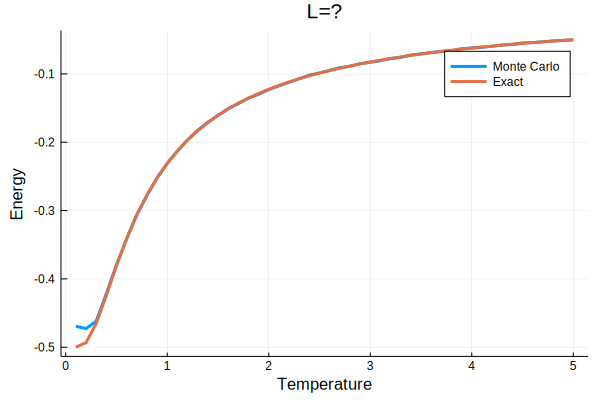

In [8]:
using Plots

plot(Tarr, [EMC, Eexact], title = "L=?", label = ["Monte Carlo" "Exact"], lw = 3 )
xlabel!("Temperature")
ylabel!("Energy")

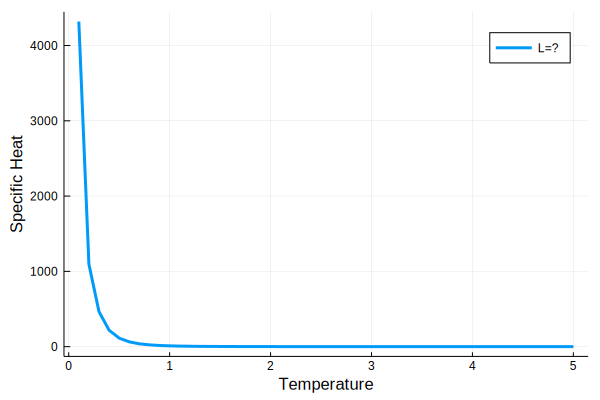

In [9]:
plot(Tarr, SpecHeat, label = "L=?", lw = 3 )
xlabel!("Temperature")
ylabel!("Specific Heat")